# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [10]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [12]:
default_seed = 1
output_file = "output_sample"

In [13]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [14]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [80]:
data.columns.tolist()

['id',
 'loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'recoveries',
 'last_pymnt_d',
 'loan_length',
 'term_num',
 'ret_PESS',
 'ret_OPT',
 'ret_INTa',
 'ret_INTb',
 'outcome',
 'cr_hist',
 'train']

In [61]:
discrete_features

['verification_status',
 'grade',
 'purpose',
 'term',
 'emp_length',
 'home_ownership']

In [79]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'int_rate',
 'revol_util',
 'cr_hist']

In [20]:
data['loan_status'].value_counts()

Fully Paid                                             835569
Charged Off                                            228051
Late (31-120 days)                                      32637
In Grace Period                                         18668
Late (16-30 days)                                        8642
Default                                                   910
Does not meet the credit policy. Status:Fully Paid        701
Does not meet the credit policy. Status:Charged Off       254
Name: loan_status, dtype: int64

In [30]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = [ (x == "Charged Off" or x == "Default")  for x in data['loan_status']]

In [48]:
data.earliest_cr_line = pd.to_datetime(data.earliest_cr_line)

In [49]:
data.earliest_cr_line

45        2004-08-01
114       2009-02-01
129       2012-08-01
155       2005-02-01
213       2008-08-01
             ...    
2777768   2002-09-01
2777770   2009-09-01
2777771   2005-03-01
2777772   2007-10-01
2777775   1995-07-01
Name: earliest_cr_line, Length: 1125432, dtype: datetime64[ns]

In [50]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [51]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])

In [52]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [53]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [54]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [60]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
45,164190449,15000.0,15000.0,60 months,23.05,D,7 years,MORTGAGE,63800.0,Source Verified,...,2020-02-01,2.037003,60,0.001793,0.052807,0.002236,0.002564,False,183.987351,True
114,163396715,12000.0,12000.0,36 months,7.56,A,10+ years,RENT,80000.0,Not Verified,...,2020-01-01,1.018501,36,0.000217,0.007670,0.000579,0.000912,False,129.941067,False
129,164160069,18825.0,18825.0,36 months,6.46,A,< 1 year,OWN,95000.0,Source Verified,...,2020-01-01,1.018501,36,0.000730,0.025803,0.000888,0.001221,False,87.985380,True
155,164174325,9075.0,9075.0,36 months,6.46,A,5 years,MORTGAGE,94000.0,Not Verified,...,2020-01-01,1.018501,36,0.000179,0.006337,0.000557,0.000889,False,177.942052,True
213,164107998,6000.0,6000.0,36 months,16.95,C,5 years,MORTGAGE,83200.0,Source Verified,...,2020-01-01,1.018501,36,0.005237,0.185114,0.003598,0.003936,False,135.986365,True


In [64]:
## define your set of features to use in different models
your_features = discrete_features + continuous_features
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Non-tuned NB
Fit time: 0.11 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999999999799059
Accuracy:  0.7946
              precision    recall  f1-score   support

  No default     0.7996    0.9898    0.8846     15906
     Default     0.4776    0.0364    0.0676      4094

    accuracy                         0.7946     20000
   macro avg     0.6386    0.5131    0.4761     20000
weighted avg     0.7337    0.7946    0.7174     20000



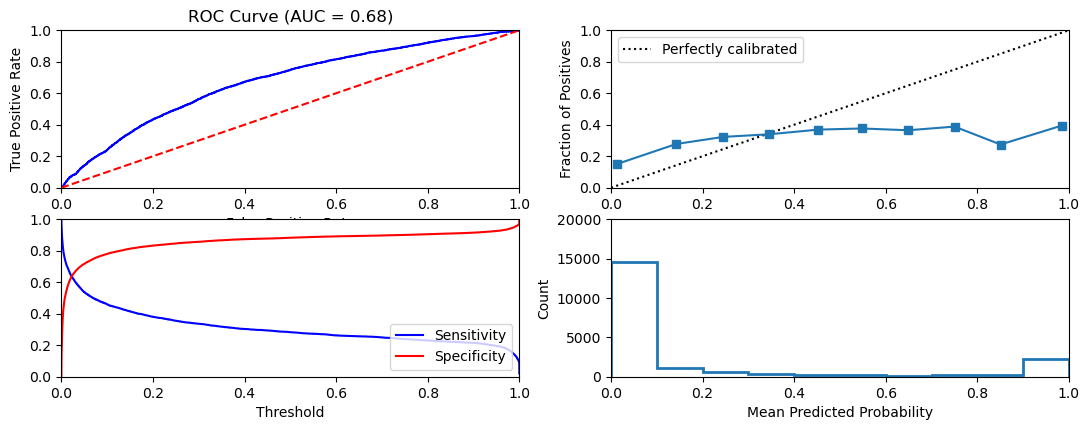


Similarity to LC grade ranking:  0.6480185612698431
Brier score: 0.213187195556488
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.76043333]


In [67]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                          cv_parameters = {},
                          model_name = 'Non-tuned NB',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### $l_1$ regularized logistic regression

  Model: Non-tuned L1
Fit time: 10.26 seconds
Optimal parameters:
{'penalty': 'l1', 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.4737207853257804
Accuracy:  0.7973
              precision    recall  f1-score   support

  No default     0.8065    0.9803    0.8850     15906
     Default     0.5299    0.0865    0.1487      4094

    accuracy                         0.7973     20000
   macro avg     0.6682    0.5334    0.5168     20000
weighted avg     0.7499    0.7973    0.7342     20000



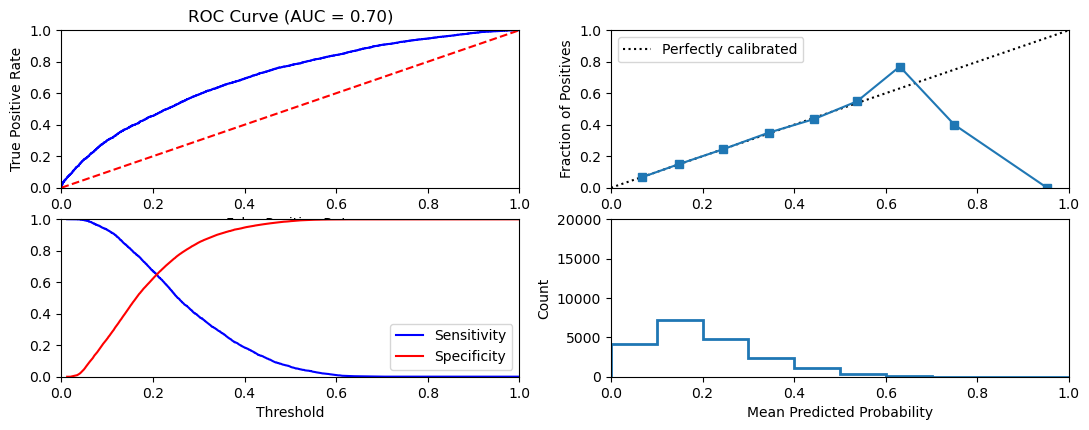


Similarity to LC grade ranking:  0.7379066218509835
Brier score: 0.14817814198730642
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.7984]


In [72]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression()
cv_parameters = {'penalty':['l1'],
    'solver' : ['liblinear']}

l1_logistic = fit_classification(l1_logistic, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned L1',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### $l_2$ regularized logistic regression

In [73]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = RidgeClassifier()
cv_parameters = {}

l2_logistic = fit_classification(l2_logistic, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned L2',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

  Model: Non-tuned L2
Fit time: 0.67 seconds
Optimal parameters:
{}

Accuracy:  0.79865
              precision    recall  f1-score   support

  No default     0.8008    0.9942    0.8871     15906
     Default     0.6324    0.0391    0.0736      4094

    accuracy                         0.7986     20000
   macro avg     0.7166    0.5166    0.4803     20000
weighted avg     0.7663    0.7986    0.7205     20000


Similarity to LC grade ranking:  0.7213046765661582


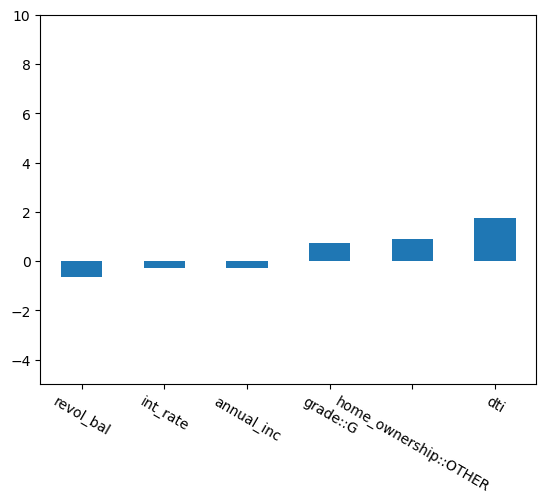

In [74]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Non-tuned DT
Fit time: 1.59 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1.0
Accuracy:  0.7953
              precision    recall  f1-score   support

  No default     0.7953    1.0000    0.8860     15906
     Default     0.0000    0.0000    0.0000      4094

    accuracy                         0.7953     20000
   macro avg     0.3977    0.5000    0.4430     20000
weighted avg     0.6325    0.7953    0.7046     20000



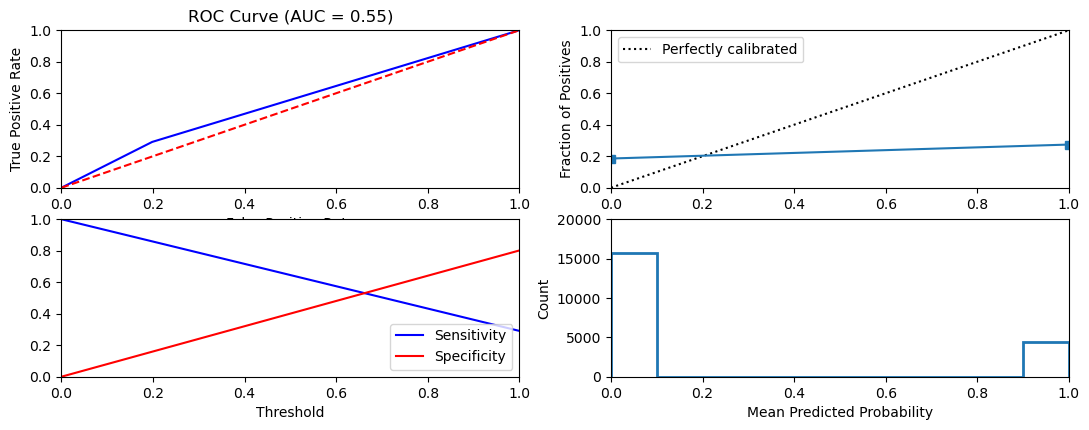


Similarity to LC grade ranking:  0.22611771205536027
Brier score: 0.3029
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.70006667]


In [75]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {}

decision_tree = fit_classification(decision_tree, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned DT',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### Random forest

  Model: Non-tuned RF
Fit time: 15.03 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5
Accuracy:  0.8006
              precision    recall  f1-score   support

  No default     0.8067    0.9854    0.8871     15906
     Default     0.5930    0.0826    0.1449      4094

    accuracy                         0.8006     20000
   macro avg     0.6998    0.5340    0.5160     20000
weighted avg     0.7629    0.8006    0.7352     20000



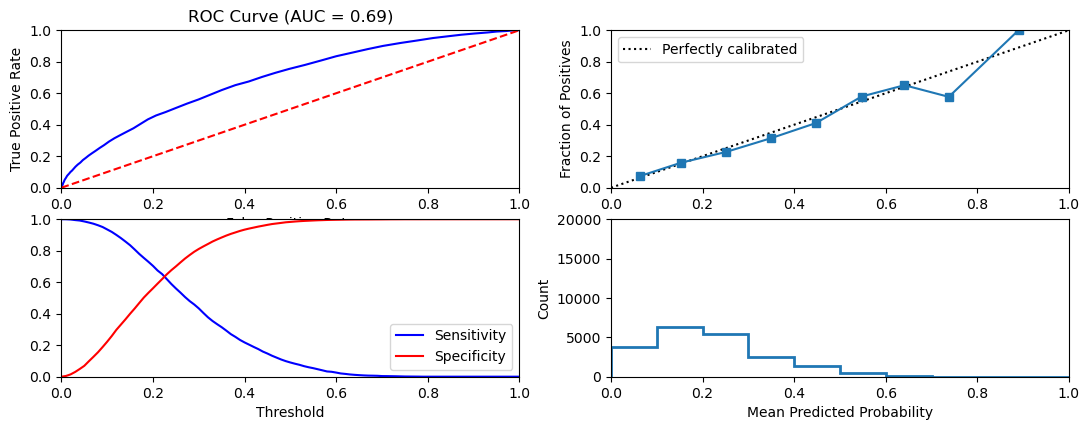


Similarity to LC grade ranking:  0.4895756341323999
Brier score: 0.14972258
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79746667]


In [76]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned RF',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

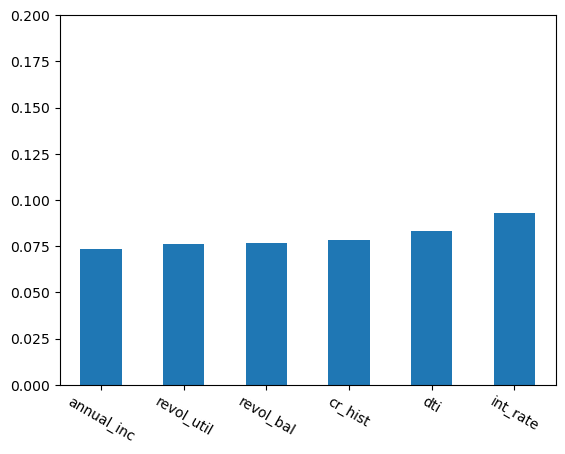

In [77]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Non-tuned RF
Fit time: 285.18 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (64, 64, 64, 64), 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.5093527643114225
Accuracy:  0.7978
              precision    recall  f1-score   support

  No default     0.8011    0.9921    0.8864     15906
     Default     0.5833    0.0427    0.0797      4094

    accuracy                         0.7978     20000
   macro avg     0.6922    0.5174    0.4830     20000
weighted avg     0.7565    0.7978    0.7213     20000



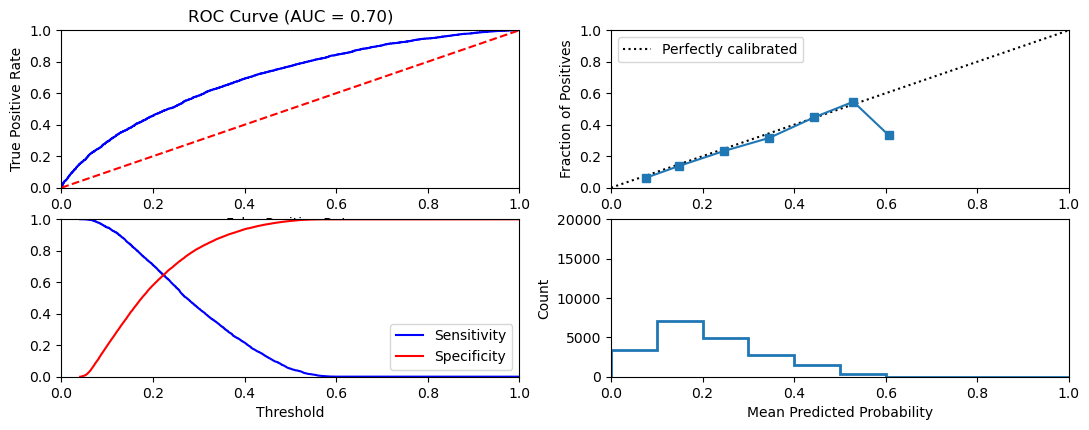


Similarity to LC grade ranking:  0.7156654003754331
Brier score: 0.1488726856671412
Were parameters on edge? : True
Score variations around CV search grid : 9.507689735874287
[0.7976     0.72176667        nan]


In [78]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(max_iter=2000)
cv_parameters = {'hidden_layer_sizes': [(64,64,64,64)],
              'activation': ['logistic', 'relu', 'sigmoid'],
              'solver': ['adam'], 
              'alpha': [0.01]}

mlp = fit_classification(mlp, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned RF',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

## Train and Test logistic regression model with features derived by LendingClub

In [86]:
lendingclub_features = ["grade","dti","fico_range_high","fico_range_low"]

  Model: Non-tuned L1 with lending
Fit time: 0.16 seconds
Optimal parameters:
{'penalty': 'l1', 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7953
              precision    recall  f1-score   support

  No default     0.7953    1.0000    0.8860     15906
     Default     0.0000    0.0000    0.0000      4094

    accuracy                         0.7953     20000
   macro avg     0.3977    0.5000    0.4430     20000
weighted avg     0.6325    0.7953    0.7046     20000



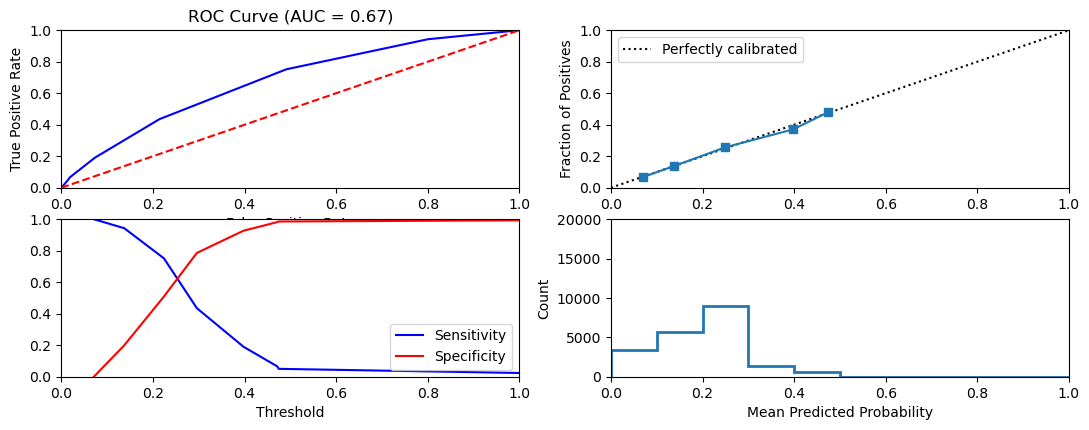


Similarity to LC grade ranking:  0.9992051516213207
Brier score: 0.15252109256069638
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.7966]


In [82]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ["grade"]

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression()

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict,
                          cv_parameters = {'penalty':['l1'],
                                          'solver' : ['liblinear']},
                          model_name = 'Non-tuned L1 with lending',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

  Model: Non-tuned L2 with lending
Fit time: 0.34 seconds
Optimal parameters:
{'penalty': 'l2'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7953
              precision    recall  f1-score   support

  No default     0.7953    1.0000    0.8860     15906
     Default     0.0000    0.0000    0.0000      4094

    accuracy                         0.7953     20000
   macro avg     0.3977    0.5000    0.4430     20000
weighted avg     0.6325    0.7953    0.7046     20000



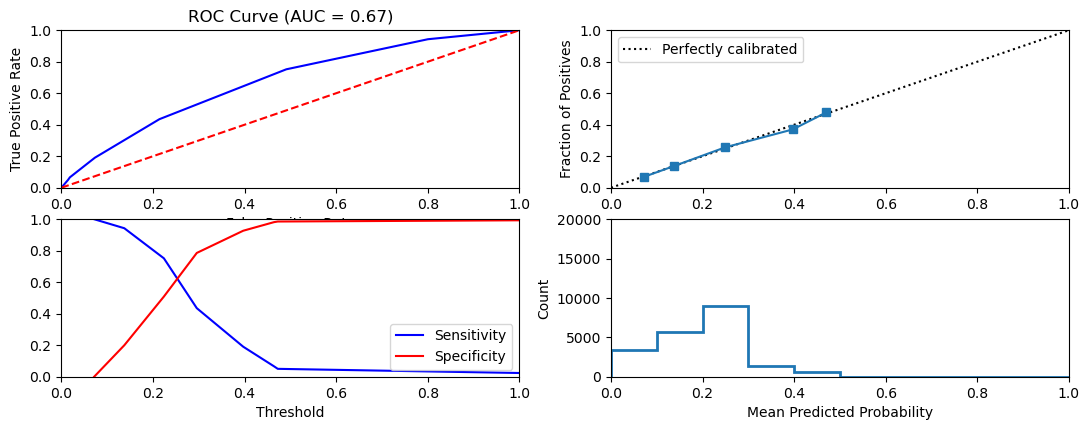


Similarity to LC grade ranking:  0.9992051516213207
Brier score: 0.1525237788673585
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.7966]


In [84]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression()

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict,
                          cv_parameters = {'penalty':['l2']},
                          model_name = 'Non-tuned L2 with lending',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [91]:
## define your set of features to use in different models
your_features = discrete_features + continuous_features
your_features = [x for x in your_features if x not in lendingclub_features]
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)


  Model: Non-tuned L1 without LC
Fit time: 7.29 seconds
Optimal parameters:
{'penalty': 'l1', 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.49132239881731576
Accuracy:  0.7958
              precision    recall  f1-score   support

  No default     0.8039    0.9830    0.8845     15906
     Default     0.5091    0.0686    0.1210      4094

    accuracy                         0.7958     20000
   macro avg     0.6565    0.5258    0.5027     20000
weighted avg     0.7436    0.7958    0.7282     20000



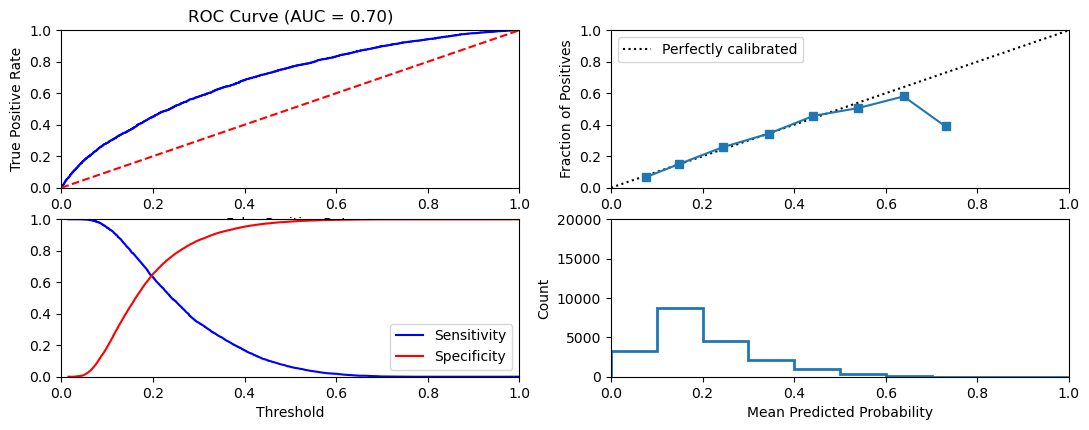


Similarity to LC grade ranking:  0.6562064322676843
Brier score: 0.14972055844284787
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.79623333]


In [94]:
l1_logistic = LogisticRegression()
cv_parameters = {'penalty':['l1'],
    'solver' : ['liblinear']}

l1_logistic = fit_classification(l1_logistic, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned L1 without LC',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

  Model: Non-tuned DT without LC
Fit time: 1.23 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1.0
Accuracy:  0.7953
              precision    recall  f1-score   support

  No default     0.7953    1.0000    0.8860     15906
     Default     0.0000    0.0000    0.0000      4094

    accuracy                         0.7953     20000
   macro avg     0.3977    0.5000    0.4430     20000
weighted avg     0.6325    0.7953    0.7046     20000



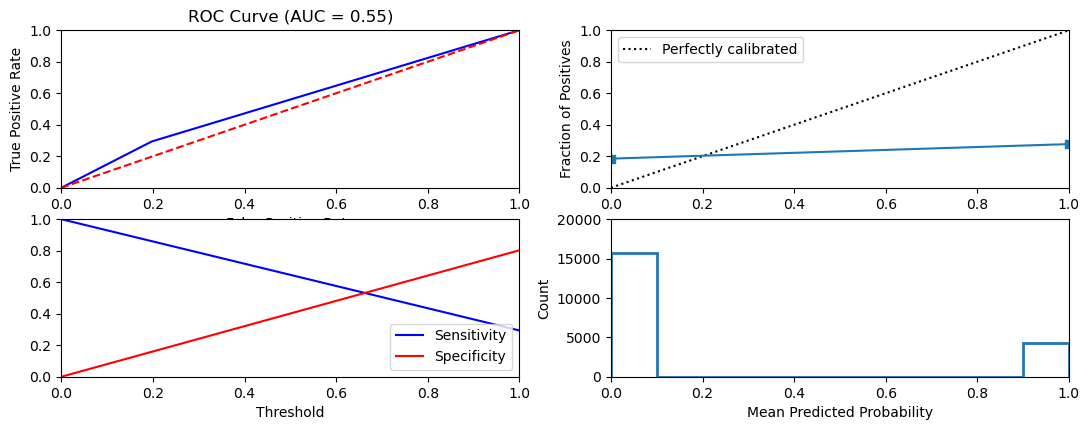


Similarity to LC grade ranking:  0.22611771205536027
Brier score: 0.3015
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.6937]


In [95]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {}

decision_tree = fit_classification(decision_tree, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned DT without LC',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

  Model: Non-tuned RF with LC
Fit time: 454.45 seconds
Optimal parameters:
{'bootstrap': True, 'max_features': 'auto', 'n_estimators': 1800}

Accuracy-maximizing threshold was: 0.6133333333333333
Accuracy:  0.79635
              precision    recall  f1-score   support

  No default     0.7968    0.9986    0.8864     15906
     Default     0.6567    0.0107    0.0211      4094

    accuracy                         0.7964     20000
   macro avg     0.7268    0.5047    0.4538     20000
weighted avg     0.7681    0.7964    0.7092     20000



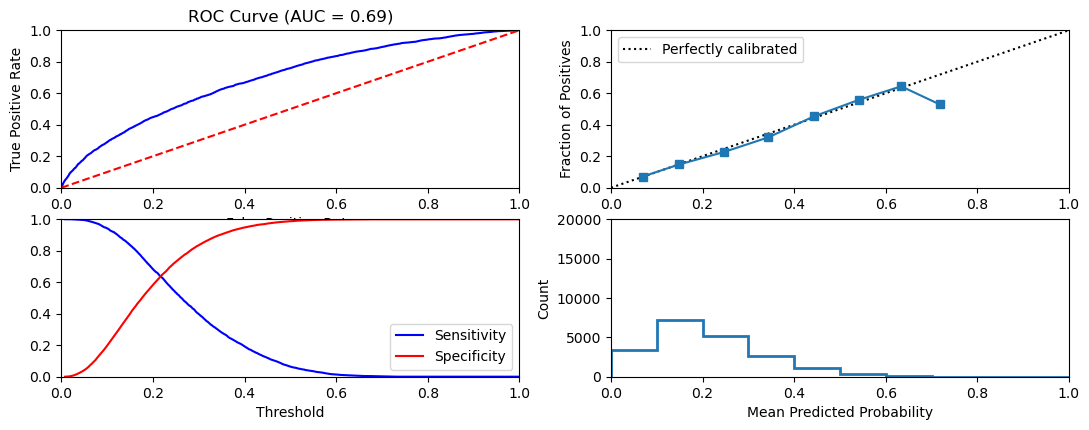


Similarity to LC grade ranking:  0.5274203338826908
Brier score: 0.14938958453703705
Were parameters on edge? : True
Score variations around CV search grid : 0.025085709507495065
[0.79726667 0.79706667]


In [99]:
random_forest = RandomForestClassifier()
cv_parameters = {'bootstrap': [True],
 'max_features': ['auto'],
 'n_estimators': [1800, 2000]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'Non-tuned RF with LC',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

## Time stability test of YOURMODEL

In [115]:
data[(data['issue_d'] >= datetime.datetime(2010, 1, 1))\
     & (data['issue_d'] <= datetime.datetime(2010, 12, 31))]['issue_d']

346605   2010-12-01
346628   2010-12-01
346639   2010-12-01
346641   2010-12-01
346643   2010-12-01
            ...    
365892   2010-01-01
365893   2010-01-01
365894   2010-01-01
365895   2010-01-01
365897   2010-01-01
Name: issue_d, Length: 12288, dtype: datetime64[ns]

In [123]:
## Define the time window of your train and test data
start_date_train = datetime.datetime(2010, 1, 1)
end_date_train = datetime.datetime(2010, 12, 31)
start_date_test = datetime.datetime(2010, 1, 1)
end_date_test = datetime.datetime(2010, 12, 31)

# data_2009 = data[(data['issue_d'] >= datetime.datetime(2010, 1, 1)) & (data['issue_d'] <= datetime.datetime(2009, 12, 31))]
# count_2009 = len(data_2009)

# # Filter the data for the year 2017
# data_2017 = data[(data['issue_d'] >= datetime.datetime(2017, 1, 1)) & (data['issue_d'] <= datetime.datetime(2017, 12, 31))]
# count_2017 = len(data_2017)

## Set n_samples_train and n_samples_test based on the actual data counts
# n_samples_train = min(9000, count_2009)  # Never exceed the number of available samples
# n_samples_test = min(7000, count_2017) 

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 3500, n_samples_test = 3500, feature_subset = your_features)

## Train and test YOURMODEL using this data
# cv_parameters = ...

# fit_classification(...)

## Train and test YOURMODEL on the original data

In [ ]:
...

## Test regression models

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = ...

reg_lasso = fit_regression(...)

### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = ...

reg_ridge = fit_regression(...)

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = ...

reg_mlp = fit_regression(...)

### Random forest regressor

In [ ]:
## trying random forest regression with hyper-parameters

cv_parameters = ...

reg_rf = fit_regression(...)

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = ...

            ## Find the average return for these loans
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = ...

            ## Find their return
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = ...

            ## Find the average return for these loans
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = ...

            ## Find their return
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

In [ ]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

In [ ]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

In [ ]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = ...

reg_separate = fit_regression(...)

print('strategy:',test_strategy)
strat_defret = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

## Sensitivity test of portfolio size

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(...)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()